# Kaggle Titanic Competition Notebook

## 1. Loading Tabular Data And Packages

The datasets for training and test data are loaded as files `train.csv` and `test.csv` as downloaded from the Kaggle competition, which can be accessed [here](https://www.kaggle.com/c/titanic).

In [2]:
#First load up any packages that will be needed
import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn as sk
import statsmodels.api as sm
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier

In [3]:
#Load training and test data into separate dataframes
pwd = os.getcwd()
root = Path('input', 'titanic')
file = 'train.csv'
df_raw_train = pd.read_csv(root / file)
file = 'test.csv'
df_raw_test = pd.read_csv(root / file)

#Examine dataframe to see ensure data is loaded correctly
df_raw_train.head()
#df_raw_test.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 2. Examine Raw Variables

As seen from the output of the first few rows of data, the training data includes a `PassengerId` column, a `Survived` binary data column to indicate whether or not the given passenger survived with a 1 for survived and a 0 for did not survive, and a `Pclass` column to indicate the class the passenger was a member of. There is also data to indicate the passenger's name including title, their sex, the number of siblings and/or spouse they may have with them denoted by `SibSp`, the number of parents of children accompanying in the passenger denoted by `ParCh`. Finally, the remaining columns deal with the ticketing information of the passenger including their `Ticket` number, the `Fare` they paid for the ticket, the `Cabin` they were staying in and finally the port they embarked from (Southampton, Cherbourg or Queenstown) denoted by the first letter of the port city in `Embarked`.

Examining the data from the datasets, the training set 891 rows and 12 columns while the testing set has 418 rows and 11 columns. The difference in columns is due to the testing set not containing the `Survived` column. This combines for 1309 rows and 12 columns with a roughly 70/30 split for training to testing data.

There also appears to be a large amount of missing data, especially in the `Cabin`, and to a lesser extent, the `Age` columns.

In [5]:
#Get number of rows and columns of data in the training dataset
print(df_raw_train.shape)
#Get number of non-null entries in each column, as well as the datatype of each column
df_raw_train.info()
#Get information on data contained in each column including number of unique entries, mean, standard deviation, minimum and maximum values and median value
df_raw_train.describe(include='all')

(891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [6]:
#Repeat process for the testing dataset
print(df_raw_test.shape)
#Get number of non-null entries in each column, as well as the datatype of each column
df_raw_test.info()
#Get information on data contained in each column including number of unique entries, mean, standard deviation, minimum and maximum values and median value
df_raw_test.describe(include='all')

(418, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Kelly, Mr. James",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


In [7]:
#Find and return any duplicated rows to see if data was repeated
df_raw_train[df_raw_train.duplicated(keep=False)]
#df_raw_test[df_raw_test.duplicated(keep=False)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


As the duplicate dataframe is empty, there is no duplicated data in the training or testing dataset.

Total missing values:  PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


Text(0.5, 1.0, 'Training dataset missing values heatmap')

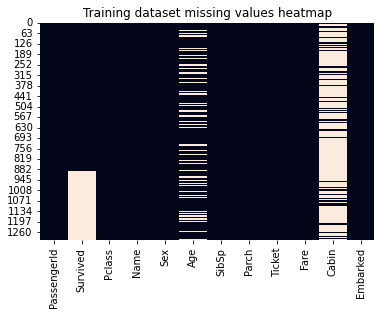

In [8]:
#Find number and locations of missing/NaN values in each category for combined training and test datasets
print("Total missing values: ", df_raw_train.drop(labels='Survived', axis=1).isnull().sum() + df_raw_test.isnull().sum())
sns.heatmap(pd.concat([df_raw_train, df_raw_test], ignore_index=True, sort  = False).isnull(), cbar=False).set_title("Training dataset missing values heatmap")

As seen from the heatmap, there are a total of 1014 missing entries in the `Cabin` column and 263 missing entries in the `Age` column across the combined training and testing dataset. The column `Fare` had one missing entry and `Embarked` had two missing entries.

# 3. Exploratory Data Analysis (EDA):

The next step in predictive analytics is to explore the underlying data structure. 

To begin, univariate analysis can be performed by creating box plots for the numerical columns `Age`, `ParCh`, `SibSp`, and `Fare`. This is a graphical format for displaying the information that is mostly shown by the `.describe()` method performed above.

The `Age` box plot shows that the median passenger on the Titanic was 28 years of age, with the interquartile range of passenger age being between 21 and 39 years of age. There are no outliers towards the minimum end of the data as the 0th percentile age was very close to 0. There are however several outliers; the 100th percentile age appears to be roughly 65 years old, however the data shows several outliers above this threshold.

The `ParCh` box plot indicates that the significant majority of passengers onboard the Titanic were travelling with no parents or children as the 0th, 25th, 50th, 75th and 100th percentile figures are all exactly 0. There were however many families onboard with between 1 and 9 parents/children. These can be considered outliers.

The 3rd box plot for `SibSp` shows that the 3rd quartile value for number of siblings and/or spouse aboard was 1 which means a majority of the passengers were travelling alone or with a single sibling/spouse. The 100th percentile number for `SibSp` is 2 with outliers at 3,4,5, and 8.

The final `Fare` boxplot shows the median fare was $14.45. The interquartile range was between $7.90 and $31.28 with a 0th percentile value of 0 and a 100th percentile value around $60. There were a significant number of outliers above this 100th percentile value, all the way out to a staggering $512.

,Age,Parch,SibSp,Fare
count,1046.000000,1309.000000,1309.000000,1308.000000
mean,29.881138,0.385027,0.498854,33.295479
std,14.413493,0.865560,1.041658,51.758668
min,0.170000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,14.454200
75%,39.000000,0.000000,1.000000,31.275000
max,80.000000,9.000000,8.000000,512.329200


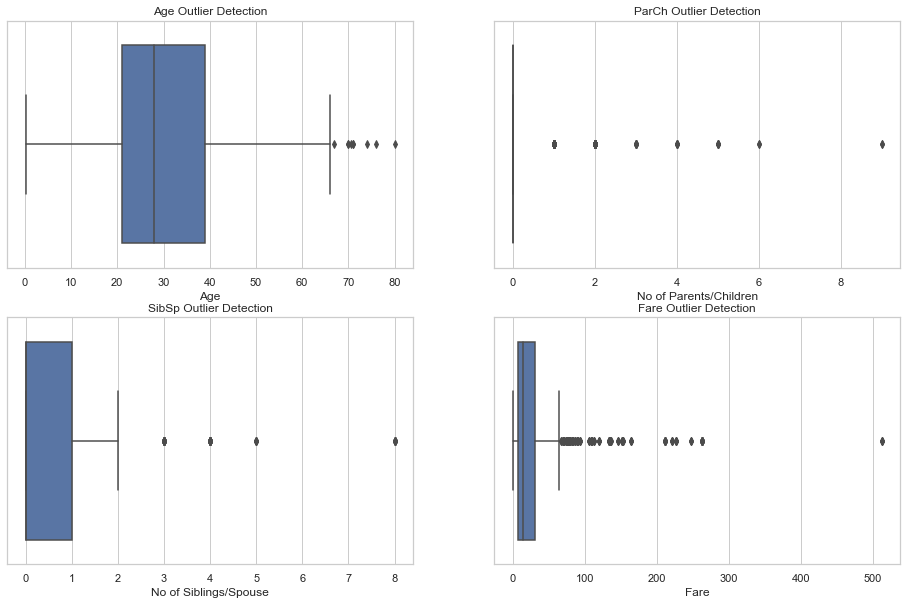

In [9]:
plt.figure(figsize= (16,10))
sns.set_theme(style="whitegrid")
plt.subplot(2,2,1); sns.boxplot(x='Age', data=pd.concat([df_raw_train, df_raw_test])); plt.xlabel("Age"); plt.title("Age Outlier Detection")
plt.subplot(2,2,2); sns.boxplot(x='Parch', data=pd.concat([df_raw_train, df_raw_test])); plt.xlabel("No of Parents/Children"); plt.title("ParCh Outlier Detection");
plt.subplot(2,2,3); sns.boxplot(x='SibSp', data=pd.concat([df_raw_train, df_raw_test])); plt.xlabel("No of Siblings/Spouse"); plt.title("SibSp Outlier Detection");
plt.subplot(2,2,4); sns.boxplot(x='Fare', data=pd.concat([df_raw_train, df_raw_test])); plt.xlabel("Fare"); plt.title("Fare Outlier Detection");
#Get numerical values for interquartile range and median
pd.concat([df_raw_train, df_raw_test]).filter(items=['Age', 'Parch', 'SibSp', 'Fare'], axis=1).describe(include='all')

After this, examine the raw data for `Survived`.

In [37]:
df_raw_train[df_raw_train['Survived'] == 1].shape[0]

342

This data indicates only 342 of 891 training cases survived, resulting in a 38.39% chance of survival. This means that 549 of the training cases or 61.61% of the cases did not survive.

The next step is to plot the other features to see how they compare against `Survived`.

In [4]:
#Create variables for plotting
labels = ["Did Not Survive", "Survived"]
palettes = {0: 'r', 1: 'b', 'male': 'r', 'female': 'b'}

#Create copy of training data to plot
df_plot_hist = df_raw_train.copy()

##### Observations from plots:

#### 1. `Pclass`

The first plots for `Pclass` show that `Pclass` is an **ordinal feature** representing first, second and third class passengers.
The data shows that third class has by far the most passengers, more than first and second class combined. Second class has the second highest number of passengers and first class has the least. Passenger class is denoted on the plots below as "Pax Class", for brevity.

The survival rate for a third class passenger is approximately one third the survival rate for a first class passenger, at just over 20% compared to over 60% respectively. Second class passengers have approximately a 50% chance to survive. The chances of survival for a passenger increase with class.
This shows that `Pclass` is an important feature.

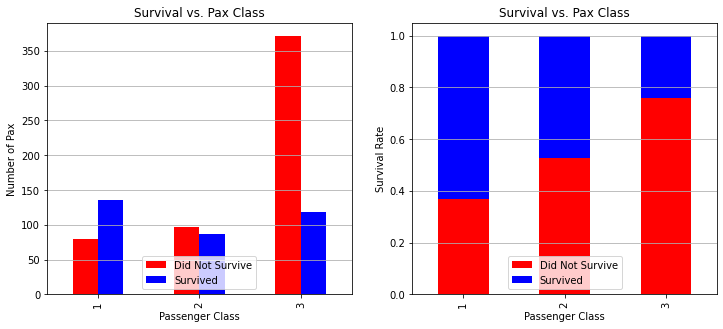

In [6]:
plt.figure(figsize=(12,5))

#Plot Survival Rate vs Passenger Class
plot_info = pd.crosstab(df_raw_train['Pclass'], df_raw_train['Survived'].astype(bool))
plt.subplot(1, 2, 1)
plot_info.plot(kind='bar', stacked=False, color=['r','b'], ax=plt.gca())
plt.grid(axis='y'); plt.legend(labels, loc='lower center'); plt.xlabel("Passenger Class"); plt.ylabel("Number of Pax"); plt.title("Survival vs. Pax Class")
plt.subplot(1, 2, 2)
plot_info.div(plot_info.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=['r','b'], ax=plt.gca())
plt.grid(axis='y'); plt.legend(labels, loc='lower center'); plt.xlabel("Passenger Class"); plt.ylabel("Survival Rate"); plt.title("Survival vs. Pax Class")

plt.show()

#### 2. `Sex`

`Sex` is a **categorical feature** for the sex of passengers. Male passengers made up approximately two thirds of the total passengers, but had a much lower chance of surival. Over 80% of male passengers did not survive while only 30% of female passengers did not survive. This is another important feature.

When combined with the `Pclass` feature, it is clear that female passengers irrespective of class had a higher survival chance than male passengers of any class. Female passengers in first class had a near 100% survival rate and female passengers in second class had a 90% chance of survival, compared to 40% and 20% for men in first and second class respectively. In third class, female passengers had a 50% chance of survival compared to 10% for men.

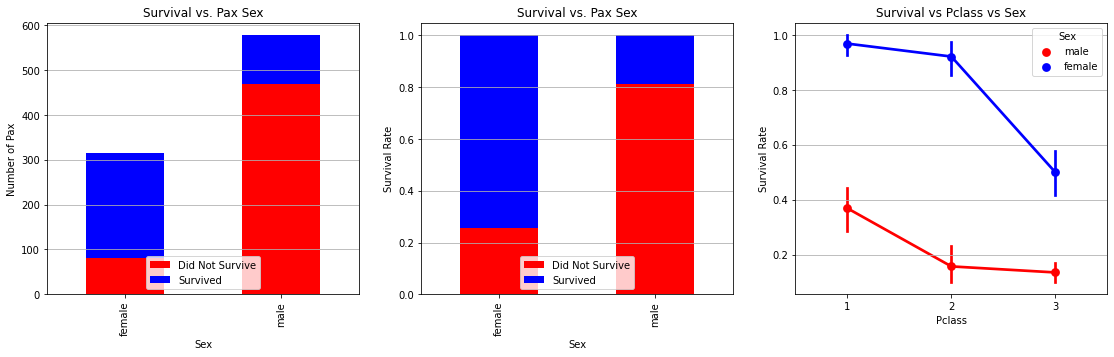

In [8]:
plt.figure(figsize=(19,5))

#Plot Survival Rate vs Passenger Sex
plot_info = pd.crosstab(df_raw_train['Sex'], df_raw_train['Survived'].astype(bool))
plt.subplot(1, 3, 1)
plot_info.plot(kind='bar', stacked=True, color=['r','b'], grid=False, ax=plt.gca())
plt.grid(axis='y'); plt.legend(labels, loc='lower center'); plt.ylabel("Number of Pax"); plt.title("Survival vs. Pax Sex")
plt.subplot(1, 3, 2)
plot_info.div(plot_info.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=['r','b'], grid=False, ax=plt.gca())
plt.grid(axis='y'); plt.legend(labels, loc='lower center'); plt.ylabel("Survival Rate"); plt.title("Survival vs. Pax Sex")
plt.subplot(1, 3, 3)
sns.pointplot(x='Pclass', y='Survived', hue='Sex', data=df_raw_train, palette=palettes, saturation=1, ax=plt.gca())
plt.grid(axis='y'); plt.ylabel("Survival Rate"); plt.title("Survival vs Pclass vs Sex")

plt.show()

#### 3. `SibSp`

The next plots for `SibSp` show that `SibSp` is a **numerical feature**. Confirming the findings from the box plot of the `SibSp` feature, around 600 passengers travelled alone and approximately 200 passengers travelled with only a single sibling or spouse. Having a single sibling or spouse resulted in the highest survival odds, closely followed by 2 siblings/spouse and then lone travellers. Travellers with 3 or 4 siblings/spouse had a 75% and 80+% mortality rate and no passengers with 5 or more siblings/spouse survived.

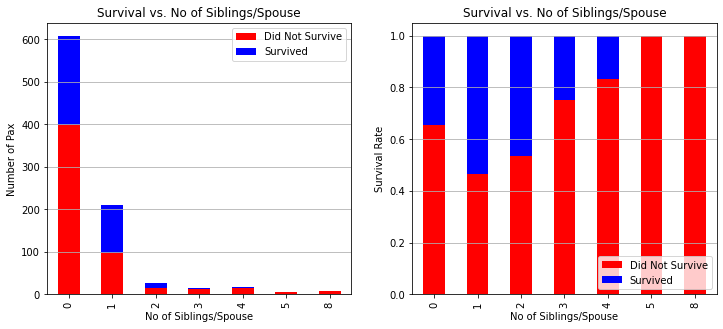

In [9]:
plt.figure(figsize=(12,5))

#Plot Survival Rate vs Number of Siblings/Spouse
plot_info = pd.crosstab(df_raw_train['SibSp'], df_raw_train['Survived'].astype(bool))
plt.subplot(1, 2, 1)
plot_info.plot(kind='bar', stacked=True, color=['r','b'], grid=False, ax=plt.gca())
plt.grid(axis='y'); plt.legend(labels, loc='upper right'); plt.xlabel("No of Siblings/Spouse"); plt.ylabel("Number of Pax"); plt.title("Survival vs. No of Siblings/Spouse")
plt.subplot(1, 2, 2)
plot_info.div(plot_info.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=['r','b'], grid=False, ax=plt.gca())
plt.grid(axis='y'); plt.legend(labels, loc='lower right'); plt.xlabel("No of Siblings/Spouse"); plt.ylabel("Survival Rate"); plt.title("Survival vs. No of Siblings/Spouse")

plt.show()

#### 4. `ParCh`

Another **numerical feature**, the `ParCh` feature also shows that the majority of the passengers (over 650 of the 891 passengers) travelled with no parents or children, confirming the findings from the box plot. The significant majority of survivors had zero immediate relatives travelling with them. 

As a percentage, the highest survival rates are for travellers with one or three relatives at over 50%. The third highest survival rate is 2 relatives at approximately 50%. Passengers with no parents or children had a roughly 75% survival rate. Passengers with 5 parents/children had a 20% survival rate. This group notably had a very small sample size, however. Passengers with any other number of parents/children did not survive.

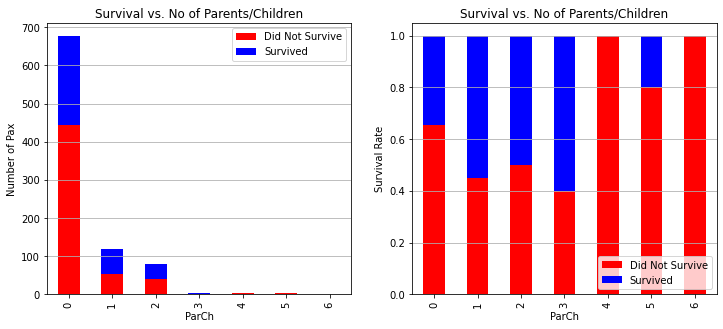

In [10]:
plt.figure(figsize=(12,5))

#Plot Survival Rate vs Number of Parents/Children
plot_info = pd.crosstab(df_raw_train['Parch'], df_raw_train['Survived'].astype(bool))
plt.subplot(1, 2, 1)
plot_info.plot(kind='bar', stacked=True, color=['r','b'], grid=False, ax=plt.gca())
plt.grid(axis='y'); plt.legend(labels, loc='upper right'); plt.xlabel("ParCh"); plt.ylabel("Number of Pax"); plt.title("Survival vs. No of Parents/Children")
plt.subplot(1, 2, 2)
plot_info.div(plot_info.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=['r','b'], grid=False, ax=plt.gca())
plt.grid(axis='y'); plt.legend(labels, loc='lower right'); plt.xlabel("ParCh"); plt.ylabel("Survival Rate"); plt.title("Survival vs. No of Parents/Children")

plt.show()

#### 5. Family Members Combined Feature

It is clear in both the `SibSp` and `ParCh` features that the majority of travellers travelled alone or with one other family member (either a sibling, spouse, parent, or child). This is an **engineered numerical feature** that takes the sum of the values in the `SibSp` and `ParCh` features to give a total number of family members travelling with the passenger. In general, small families were more likely to survive than large families or individual travellers.

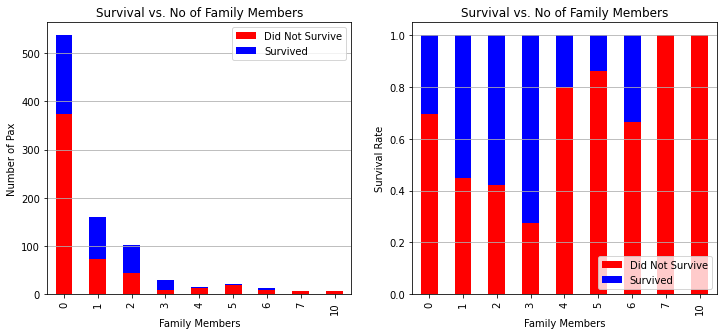

In [11]:
plt.figure(figsize=(12,5))


#Combine Survival Rate of ParCh + SibSp for Family Survival Rate
plot_info = pd.crosstab(df_raw_train['Parch'] + df_raw_train['SibSp'], df_raw_train['Survived'].astype(bool))
plt.subplot(1, 2, 1)
plot_info.plot(kind='bar', stacked=True, color=['r','b'], grid=False, ax=plt.gca())
plt.grid(axis='y'); plt.legend(labels, loc='upper right'); plt.xlabel("Family Members"); plt.ylabel("Number of Pax"); plt.title("Survival vs. No of Family Members")
plt.subplot(1, 2, 2)
plot_info.div(plot_info.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=['r','b'], grid=False, ax=plt.gca())
plt.grid(axis='y'); plt.legend(labels, loc='lower right'); plt.xlabel("Family Members"); plt.ylabel("Survival Rate"); plt.title("Survival vs. No of Family Members")

plt.show()

#### 6. `Embarked`

The plots show that `Embarked` is a **categorical feature** describing which port the passenger boarded at. Over 650 (70%) of the passengers embarked from the port of Southampton, roughly 20% of the passengers embarked from the port of Cherbourg, and the remainder of the passengers embarked at Queenstown. 

The chances of survival were greater than 50% for Cherbourg passengers while passengers who embarked from the other ports had only a roughly 40% chance of survival.

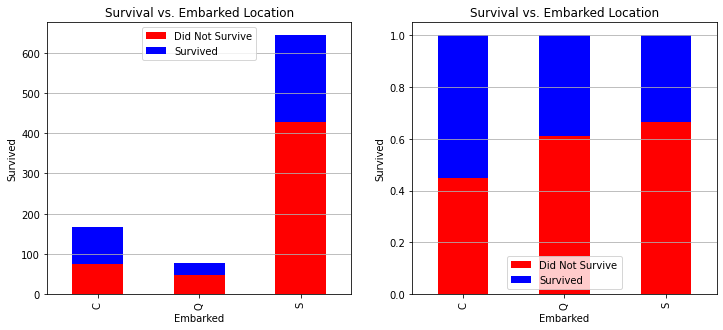

In [12]:
plt.figure(figsize=(12,5))

#Plot Survival Rate vs Embarked Location
plot_info = pd.crosstab(df_raw_train['Embarked'], df_raw_train['Survived'].astype(bool))
plt.subplot(1, 2, 1)
plot_info.plot(kind='bar', stacked=True, color=['r','b'], grid=False, ax=plt.gca())
plt.grid(axis='y'); plt.legend(labels, loc='upper center'); plt.xlabel("Embarked"); plt.ylabel("Survived"); plt.title("Survival vs. Embarked Location")
plt.subplot(1, 2, 2)
plot_info.div(plot_info.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=['r','b'], grid=False, ax=plt.gca())
plt.grid(axis='y'); plt.legend(labels, loc='lower center'); plt.xlabel("Embarked"); plt.ylabel("Survived"); plt.title("Survival vs. Embarked Location")

plt.show()

#### 7. `Fare`

`Fare` is a **numerical feature**. The raw histogram data, split between passengers who survived and who did not, shows that passengers who paid a higher fare had a higher chance of survival. This can be confirmed in the violin plot comparing deceased and survived passengers against fare, and again in the next plot when binning the fares. In the fifth plot, fares were binned using the minimum, 25th percentile, median and 75th percentile and maximum values from the box plot and `describe()` method to create four roughly equal sized bins.

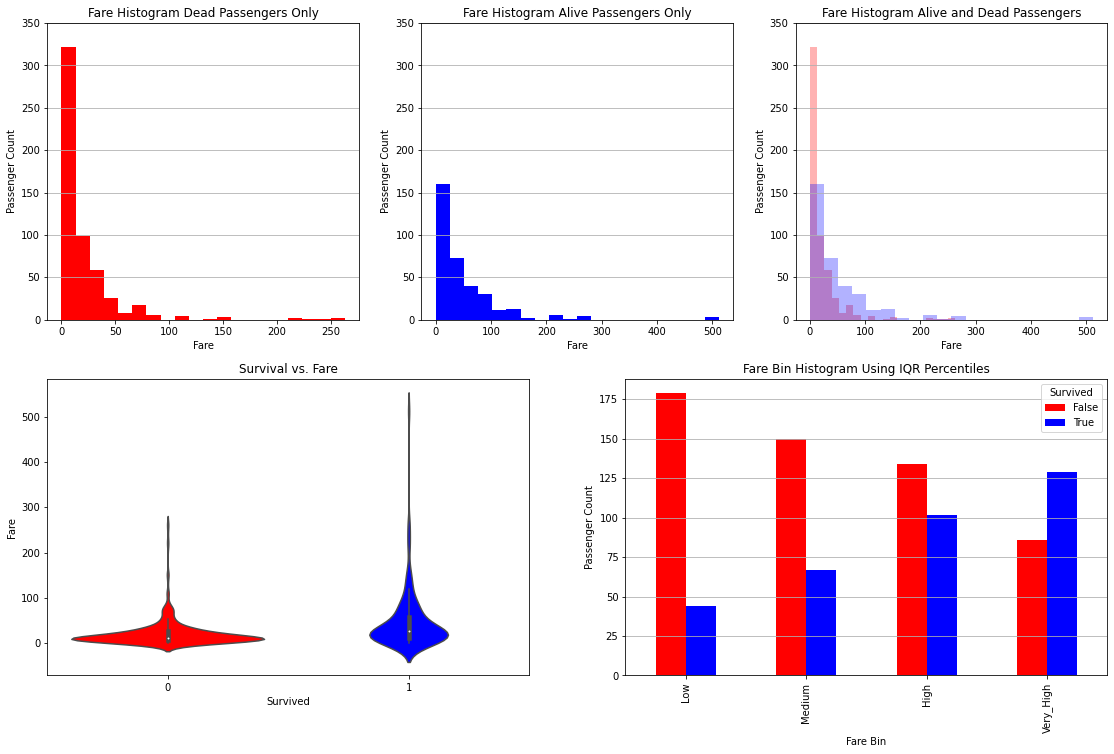

In [15]:
plt.figure(figsize=(19,12))

#Plot Histogram of Passenger Fares
df_plot_hist_alive = df_plot_hist.copy()
df_plot_hist_dead = df_plot_hist.copy()
df_plot_hist_alive = df_plot_hist_alive[df_plot_hist_alive['Survived'] == 1]
df_plot_hist_dead = df_plot_hist_dead[df_plot_hist_dead['Survived'] == 0]
plt.subplot(2, 3, 1)
df_plot_hist_dead['Fare'].plot(kind='hist', bins=20, color='r', grid=False, ylim=(0,350), ax=plt.gca())
plt.grid(axis='y'); plt.xlabel("Fare"); plt.ylabel("Passenger Count"); plt.title("Fare Histogram Dead Passengers Only")
plt.subplot(2, 3, 2)
df_plot_hist_alive['Fare'].plot(kind='hist', bins=20, color='b', grid=False, ylim=(0,350), ax=plt.gca())
plt.grid(axis='y'); plt.xlabel("Fare"); plt.ylabel("Passenger Count"); plt.title("Fare Histogram Alive Passengers Only")
plt.subplot(2, 3, 3)
df_plot_hist_dead['Fare'].plot(kind='hist', bins=20, color='r', alpha=0.3, grid=False, ylim=(0,350), ax=plt.gca())
df_plot_hist_alive['Fare'].plot(kind='hist', bins=20, color='b', alpha=0.3, grid=False, ylim=(0,350), ax=plt.gca())
plt.grid(axis='y'); plt.xlabel("Fare"); plt.ylabel("Passenger Count"); plt.title("Fare Histogram Alive and Dead Passengers")

#Plot fare vs Pclass and fare vs survival
plt.subplot(2, 2, 3)
sns.violinplot(x='Survived', y='Fare', data=df_raw_train, split=True, saturation=1, palette=palettes, ax=plt.gca())
plt.xlabel("Survived"); plt.ylabel("Fare"); plt.title("Survival vs. Fare")
plt.subplot(2, 2, 4)
df_plot_hist['Fare Bin'] = pd.cut(df_plot_hist['Fare'], bins=[-np.inf, 7.9, 14.45, 31.28, np.inf], labels=['Low', 'Medium', 'High', 'Very_High'])
plot_info = pd.crosstab(df_plot_hist['Fare Bin'], df_raw_train['Survived'].astype(bool))
plot_info.plot(kind='bar', stacked=False, color=['r','b'], grid=False, ax=plt.gca())
plt.grid(axis='y'); plt.ylabel("Passenger Count"); plt.title("Fare Bin Histogram Using IQR Percentiles")

plt.show()

#### 8. `Age`

`Age` is a **numerical feature**. The major observation from the histogram of the ages of passengers, separated by whether they survived or not, is the survival rate for passengers between 0 and 5 years of age. The survival rate for 0-5 year old children is significantly higher compared to the other age groups.

The plot also shows that for passengers whose ages fell in the outlier range from the `Age` box plot, the majority of those passengers over the age of 60 did not survive.

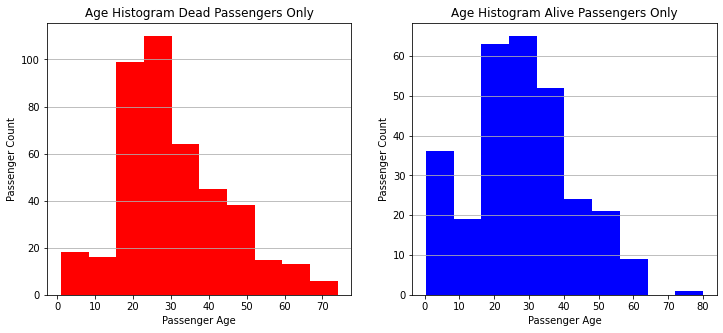

In [16]:
plt.figure(figsize=(12,5))

#Plot Histogram of Passenger Ages
plt.subplot(1, 2, 1)
df_plot_hist_dead['Age'].plot(kind='hist', bins=10, color='r', grid=False, ax=plt.gca())
plt.grid(axis='y'); plt.xlabel("Passenger Age"); plt.ylabel("Passenger Count"); plt.title("Age Histogram Dead Passengers Only")
plt.subplot(1, 2, 2)
df_plot_hist_alive['Age'].plot(kind='hist', bins=10, color='b', grid=False, ax=plt.gca())
plt.grid(axis='y'); plt.xlabel("Passenger Age"); plt.ylabel("Passenger Count"); plt.title("Age Histogram Alive Passengers Only")

plt.show()

# 4. Data Transformation

The next major step in data analysis is data transformation. Data is seldom arranged in a desired arrangement. 

Many kinds of transformations may have to be performed to get the data to the desired format, either because the data is dirty, not of the desired type, out of bounds, is incomplete, or a host of other reasons.

In [21]:
#Create copy of raw datasets
df_train = df_raw_train.copy()
df_test = df_raw_test.copy()

#Convert embarked to categorical columns with separate columns for passengers embarked from Southhampton or Cherbourg
df_train['PaxEmbarkedS'] = np.where(df_train['Embarked'] == 'S', 1, 0)
df_train['PaxEmbarkedC'] = np.where(df_train['Embarked'] == 'C', 1, 0)
df_train.drop(labels='Embarked', axis=1, inplace=True)
df_test['PaxEmbarkedS'] = np.where(df_test['Embarked'] == 'S', 1, 0)
df_test['PaxEmbarkedC'] = np.where(df_test['Embarked'] == 'C', 1, 0)
df_test.drop(labels='Embarked', axis=1, inplace=True)

#Convert Sex to 1 for male and 0 for female
df_train['Sex']  = df_train['Sex'].apply(lambda r:  1 if (r[0] == 'm') else 0)
df_test['Sex'] = df_test['Sex'].apply(lambda r: 1 if (r[0] == 'm') else 0)

#Fill in missing values for age with mean age
df_train['Age'] = df_train['Age'].replace({np.nan: df_train.describe()['Age']['mean']})
df_test['Age'] = df_test['Age'].replace({np.nan: df_test.describe()['Age']['mean']})

#Fill in missing values for fare with mean fare
df_train['Fare'] = df_train['Fare'].replace({np.nan: df_train.describe()['Fare']['mean']})
df_test['Fare'] = df_test['Fare'].replace({np.nan: df_test.describe()['Fare']['mean']})

#Combine Parent/Child (ParCh) column with Sibling/Spouse (SibSp) column to create singular Family column and IsAlone column
df_train['Family'] = df_train['Parch'] + df_train['SibSp']
df_train['IsAlone'] = np.where(df_train['Family'] == 0, 1, 0)
df_test['Family'] = df_test['Parch'] + df_test['SibSp']
df_test['IsAlone'] = np.where(df_test['Family'] == 0, 1, 0)

#Drop ticket and cabin and name columns
df_train.drop(labels=['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(labels=['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

#Check new values
df_train.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,PaxEmbarkedS,PaxEmbarkedC,Family,IsAlone
0,1,0,3,1,22.000000,1,0,7.2500,1,0,1,0
1,2,1,1,0,38.000000,1,0,71.2833,0,1,1,0
2,3,1,3,0,26.000000,0,0,7.9250,1,0,0,1
3,4,1,1,0,35.000000,1,0,53.1000,1,0,1,0
4,5,0,3,1,35.000000,0,0,8.0500,1,0,0,1
5,6,0,3,1,29.699118,0,0,8.4583,0,0,0,1
6,7,0,1,1,54.000000,0,0,51.8625,1,0,0,1
7,8,0,3,1,2.000000,3,1,21.0750,1,0,4,0
8,9,1,3,0,27.000000,0,2,11.1333,1,0,2,0
9,10,1,2,0,14.000000,1,0,30.0708,0,1,1,0


The first step is to create a copy of the data and place it in new dataframes so that any transformations performed on the raw datasets will not affect the data from the CSVs. This also allows the transformations be performed without having to load from the CSV in cases where a transformation may need to be rolled back. This is useful as some datasets can be large and take a lengthy amount of time to reload the original dataset from the CSV.

The first transformation is performed on the `Embarked` feature. Currently, there are three locations for embarked: S, C, and Q. This will be converted into two separate binary integer columns: one for Southampton passengers ('S') and one for Cherbourg passengers ('C'). This results in Southampton passengers, which make up a majority of all passengers, having a 1 in the first new feature (`PaxEmbarkedS`) and a 0 in the second new feature (`PaxEmbarkedC`). Cherbourg passengers will have a 0 in `PaxEmbarkedS` and a 1 in `PaxEmbarkedC`. Finally, passengers from Queenstown ('Q') will have a 0 in both columns. The original column can then be dropped as it will no longer be used.

The second transformation will be to convert the `Sex` feature from male/female values to binary values.

The third transformation will be to replace the missing values from the `Age` feature. This replaces the NaN/null values with the mean value of the column.

This same transformation is performed for the missing `Fare` values.

The final transformation is combine the `ParCh` and `SibSp` features into a numerical `Family` feature which is a sum of the values of the previous features and a binary `IsAlone` feature which indicates whether or not the passenger was a lone traveller.

Finally, the `Name`, `Ticket`, and `Cabin` features can be dropped as these categories will not be used.
The `Name` feature contains no useful information aside from title.
The `Ticket` information contains too many unique data entries to be useful.
The `Cabin` feature contains too many missing features to be useful and cannot be replaced.

Total missing values:  PassengerId     0
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
PaxEmbarkedS    0
PaxEmbarkedC    0
Family          0
IsAlone         0
dtype: int64


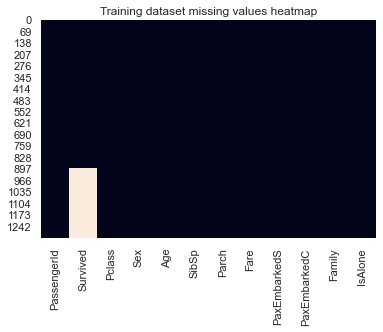

In [22]:
#Recheck for missing/NaN values
print("Total missing values: ", df_train.drop(labels='Survived', axis=1).isnull().sum() + df_test.isnull().sum())
sns.heatmap(pd.concat([df_train, df_test], ignore_index=True, sort  = False).isnull(), cbar=False).set_title("Training dataset missing values heatmap");

The heatmap confirms there are no missing values.

# 5. Feature Selection

The next step is to reduce the number of features in an attempt to reduce compute resources and to improve the performance of the model. There are several methods for feature selection, such as using recursive feature eliminiation (RFE) on a decision tree or linear model. Alternatively, a regularized linear model could be used, such as lasso that enforces sparsity, however the downside is that this method does not allow the number of desired features to be set. 

The chosen method is to use a random forest of 10,000 decision trees, each using a subset of the feature set to determine the importance score of each feature. The sum of these importance scores is 1.0.

In [23]:
#Create labels for features to be evaluated
featLabels = ['Pclass', 'Sex', 'Age', 'Parch', 'SibSp', 'Fare', 'PaxEmbarkedS', 'PaxEmbarkedC', 'Family', 'IsAlone']
#Separate x and y training data
x_train = df_train[featLabels] # features/independent variables
y_train = df_train['Survived']
#Create random forest
clf = RandomForestClassifier(n_estimators=10000, random_state=0)
#Fit random forest
clf.fit(x_train, y_train)
#Print results with importance score
for feature in zip(featLabels, clf.feature_importances_):
    print(feature)

('Pclass', 0.08111890451429112)
('Sex', 0.26067393189806987)
('Age', 0.25740486584789146)
('Parch', 0.02194948986893055)
('SibSp', 0.026929068741493336)
('Fare', 0.259560723891994)
('PaxEmbarkedS', 0.018379117008302748)
('PaxEmbarkedC', 0.014686946482124173)
('Family', 0.0479615702251252)
('IsAlone', 0.011335381521777758)


The random forest ranks the features in order of importance:
1. `Sex`
2. `Fare`
3. `Age`
4. `Pclass`
5. `Family`
6. `SibSp`
7. `ParCh`
8. `PaxEmbarkedS`
9. `PaxEmbarkedC`
10. `IsAlone`

This can be confirmed by using `SelectFromModel` from scikit-learn below.

In [24]:
featSel = SelectFromModel(clf, threshold=0.15)
featSel.fit(x_train, y_train)
for featIndex in featSel.get_support(indices=True):
    print(featLabels[featIndex])

#Reduce X to selected features - automatic
#featSel.transform(x_train)

Sex
Age
Fare


The output of the feature selection random forest confirms that the features `Sex`, `Age` and `Fare` are the most important. As well, it confirms these features are more important than the mean importance score of all features.

# 5. Model Building

Now that the variables have been explored, a model can be built. In addition to the three highest importance score features (`Sex`, `Age`, and `Fare`), the features `Pclass` and `Family` will be included to reduce the number of features from ten to five.

In [33]:
#Remove depedent variable from X
feature_labels = ['Sex', 'Fare', 'Age', 'Pclass', 'Family']
x_train = df_train[feature_labels] # features/independent variables
y_train = df_train['Survived']
x_test = df_test.filter(feature_labels, axis=1)
#Strip PassengerId to create output
y_output = df_test.filter(['PassengerId'], axis=1)

#Normalize training and testing data
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

#Function to allow allow the model to be re-run
def checkSurvivedColumn(df):
    if 'Survived' in df.columns:
        df_out = df.drop(labels='Survived', axis=1)
        return df_out
    return df
    

After creating and normalizing the data, hyperparameter tuning should be performed on the model to maximize the score and accuracy of the model. In this example, a grid search is used as it is simple and there is not a large amount of hyperparameters and not a large range of values for the hyperparameters.

When creating the model, the number of neurons in the first layer is selected to be equal to the number of features being input, in this case 5. ReLU is selected to predict positive, real numbers.
The output layer has a single neuron as the model being created is a classifier model to determine a binary outcome: whether the given passenger survives or not. This layer uses a sigmoid activation function as a 'squishing' function to create the binary output.
Finally, the hidden layer is chosen to use the ReLU activation function similar to the input layer, and has a number of neurons between the number of input layer neurons and output layer neurons.

In [35]:
#Create scikeras wrapper for model
def get_model():
    model = Sequential()
    model.add(Dense(5, input_dim= 5, activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
model = KerasClassifier(model=get_model)

#Create parameters for grid search
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [100, 200, 300, 400]
param_grid = dict(batch_size=batch_size, epochs=epochs)

#Grid search using parallelism with n_jobs=-1
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)


Epoch 1/200
90/90 [==============================] - 0s 747us/step - loss: 0.7190 - accuracy: 0.6162
Epoch 2/200
90/90 [==============================] - 0s 1ms/step - loss: 0.6778 - accuracy: 0.6162
Epoch 3/200
90/90 [==============================] - 0s 772us/step - loss: 0.6527 - accuracy: 0.6162
Epoch 4/200
90/90 [==============================] - 0s 762us/step - loss: 0.6336 - accuracy: 0.6162
Epoch 5/200
90/90 [==============================] - 0s 783us/step - loss: 0.6175 - accuracy: 0.6218
Epoch 6/200
90/90 [==============================] - 0s 818us/step - loss: 0.6017 - accuracy: 0.6655
Epoch 7/200
90/90 [==============================] - 0s 712us/step - loss: 0.5840 - accuracy: 0.7071
Epoch 8/200
90/90 [==============================] - 0s 695us/step - loss: 0.5672 - accuracy: 0.7262
Epoch 9/200
90/90 [==============================] - 0s 717us/step - loss: 0.5511 - accuracy: 0.7351
Epoch 10/200
90/90 [==============================] - 0s 751us/step - loss: 0.5364 - accuracy

Next, the results of all possible hyperparameters can be printed along with the score of each combination. The combination of hyperparameters that result in the highest score will be used for the final model.

In [29]:
#Print results of grid search
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.818182 using {'batch_size': 100, 'epochs': 400}
0.803591 (0.018305) with: {'batch_size': 10, 'epochs': 100}
0.809203 (0.022221) with: {'batch_size': 10, 'epochs': 200}
0.805836 (0.023056) with: {'batch_size': 10, 'epochs': 300}
0.801347 (0.019047) with: {'batch_size': 10, 'epochs': 400}
0.800224 (0.015632) with: {'batch_size': 20, 'epochs': 100}
0.804714 (0.012598) with: {'batch_size': 20, 'epochs': 200}
0.797980 (0.022503) with: {'batch_size': 20, 'epochs': 300}
0.802469 (0.005723) with: {'batch_size': 20, 'epochs': 400}
0.784512 (0.035950) with: {'batch_size': 40, 'epochs': 100}
0.804714 (0.013746) with: {'batch_size': 40, 'epochs': 200}
0.802469 (0.015141) with: {'batch_size': 40, 'epochs': 300}
0.801347 (0.023808) with: {'batch_size': 40, 'epochs': 400}
0.806958 (0.008399) with: {'batch_size': 60, 'epochs': 100}
0.796857 (0.010408) with: {'batch_size': 60, 'epochs': 200}
0.786756 (0.016798) with: {'batch_size': 60, 'epochs': 300}
0.795735 (0.007936) with: {'batch_size': 60,

In [38]:
#Create model
model = get_model()
#Fit model using hyperparameters from grid search
model.fit(x_train,y_train,epochs=grid_result.best_params_.get('epochs'), batch_size=grid_result.best_params_.get('batch_size'));
#Predict using model on test data
y_pred = model.predict(x_test)
#Create output dataframe, insert new column to match Kaggle submission requirements
y_output = checkSurvivedColumn(y_output)
y_output.insert(1, "Survived", y_pred)
#Rounding
y_output['Survived'] = y_output['Survived'].apply(lambda r: math.floor(r) if (r < 0.5) else math.ceil(r))
#Output to file
os.makedirs('output/titanic', exist_ok=True)
y_output.to_csv('output/titanic/out.csv', index=False)

Epoch 1/200
90/90 [==============================] - 1s 1ms/step - loss: 0.6917 - accuracy: 0.4534
Epoch 2/200
90/90 [==============================] - 0s 1ms/step - loss: 0.6432 - accuracy: 0.6902
Epoch 3/200
90/90 [==============================] - 0s 930us/step - loss: 0.6145 - accuracy: 0.7710
Epoch 4/200
90/90 [==============================] - 0s 1ms/step - loss: 0.5925 - accuracy: 0.7755
Epoch 5/200
90/90 [==============================] - 0s 919us/step - loss: 0.5753 - accuracy: 0.7767
Epoch 6/200
90/90 [==============================] - 0s 1ms/step - loss: 0.5597 - accuracy: 0.7912
Epoch 7/200
90/90 [==============================] - 0s 1ms/step - loss: 0.5458 - accuracy: 0.7935
Epoch 8/200
90/90 [==============================] - 0s 1ms/step - loss: 0.5330 - accuracy: 0.7856
Epoch 9/200
90/90 [==============================] - 0s 1ms/step - loss: 0.5215 - accuracy: 0.7890
Epoch 10/200
90/90 [==============================] - 0s 1ms/step - loss: 0.5114 - accuracy: 0.7935
Epoch

The submission generated from this code results in a poor score of 0.78229 from Kaggle which is a top 20% score. This indicates that 327 of 418 test case predictions made by the model were correct, with 91 predictions being incorrect. This is likely due to a poor performance by the model for a variety of reasons: model selection, poor selection of features, or because a model based on Keras deep learning is inappropriate for this situation. Specifically in regards to the latter reason, a classifier using another model such as decision tree, SVM, k-nearest neighbors or other model would be more appropriate and result in a higher score.